# Spectroscopic Databases from NIST

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
import numpy as np
from fractions import Fraction

- Dataframe for levels: `nist_atomic_spectra_database_levels.pkl`
- Dataframe for lines: `nist_atomic_spectra_database_lines.pkl`

Description of the lines data may be found at https://physics.nist.gov/PhysRefData/ASD/Html/lineshelp.html, and for the lines at https://physics.nist.gov/PhysRefData/ASD/Html/levelshelp.html. Static copies of these are in this folder as .md files.

In the information about levels, the information about the parity of a term is included as an asterisk in the string for the term. If present the parity is odd, if absent it is even.

Note that from parsing, additional columns were added to keep the commentaries that some numerical entries may have.

In the case of descriptors for intensity of lines, there's an additional file `nist_atomic_spectra_database_lines_intensity_descriptors.json` that may be used to grab their meaning.

Data was retrieved on March of 2021 by David.

## Helper functions

In [2]:
# http://www.noah.org/wiki/Wavelength_to_RGB_in_Python
def wavelength_to_rgb(wavelength, gamma=0.8):
    wavelength = float(wavelength)
    if wavelength < 380:
        wavelength = 380
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 1.0
        G = 0.0
        B = 0.0
    return (R, G, B)

## Free-Ion Levels

In [3]:
atomic_levels = pd.read_pickle('./nist_atomic_spectra_database_levels.pkl')

In [60]:
atomic_levels

,Element,Charge,Configuration,Term,J,g,Level (eV),Uncertainty (eV),Splitting,Leading percentages,Reference,Lande,J_uncertain,J_has_issues
0,H,0,1s,2S,[1/2],2,0.000000,1.200000e-13,,100,,NaN,False,False
1,H,0,2p,2P*,[1/2],2,10.198806,4.000000e-11,10.19880615024,100,L15291,NaN,False,False
2,H,0,2p,2P*,[3/2],4,10.198852,5.000000e-11,0.00004536435,100,L15291,NaN,False,False
3,H,0,2s,2S,[1/2],2,10.198811,1.200000e-13,-0.00004098944,100,L15291,NaN,False,False
4,H,0,2,,[],8,10.198836,1.200000e-06,0.0000253,,L15291,NaN,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,Es,96,Es XCVIII (1s2 1S<0>),Limit,[],,39451.400000,1.000000e+00,,NaN,L16264c99,NaN,False,True
0,Es,97,1s2,1S,[0],1,0.000000,1.200000e-03,,NaN,L10054,NaN,False,False
1,Es,97,Es XCIX (1s 2S<1/2>),Limit,[],,154328.100000,1.500000e+00,,NaN,L10054,NaN,False,True
0,Es,98,1s,2S,[1/2],2,0.000000,1.200000e-03,,NaN,L7188,NaN,False,False


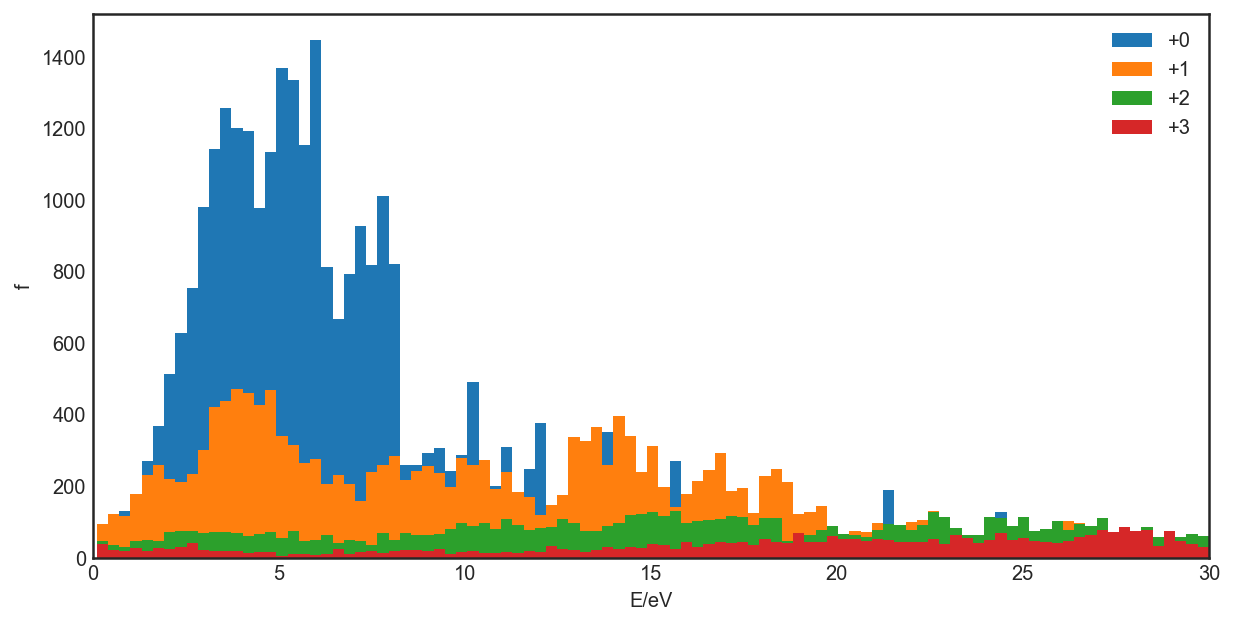

In [7]:
plt.figure(figsize=(10,5))
for charge in [0,1,2,3]:
    plt.hist(atomic_levels[atomic_levels['Charge'] == charge]['Level (eV)'],
             bins = np.linspace(0.1,30,100), label="+"+str(charge))
plt.xlim(0,30)
plt.legend()
plt.xlabel('E/eV')
plt.ylabel('f')
plt.show()

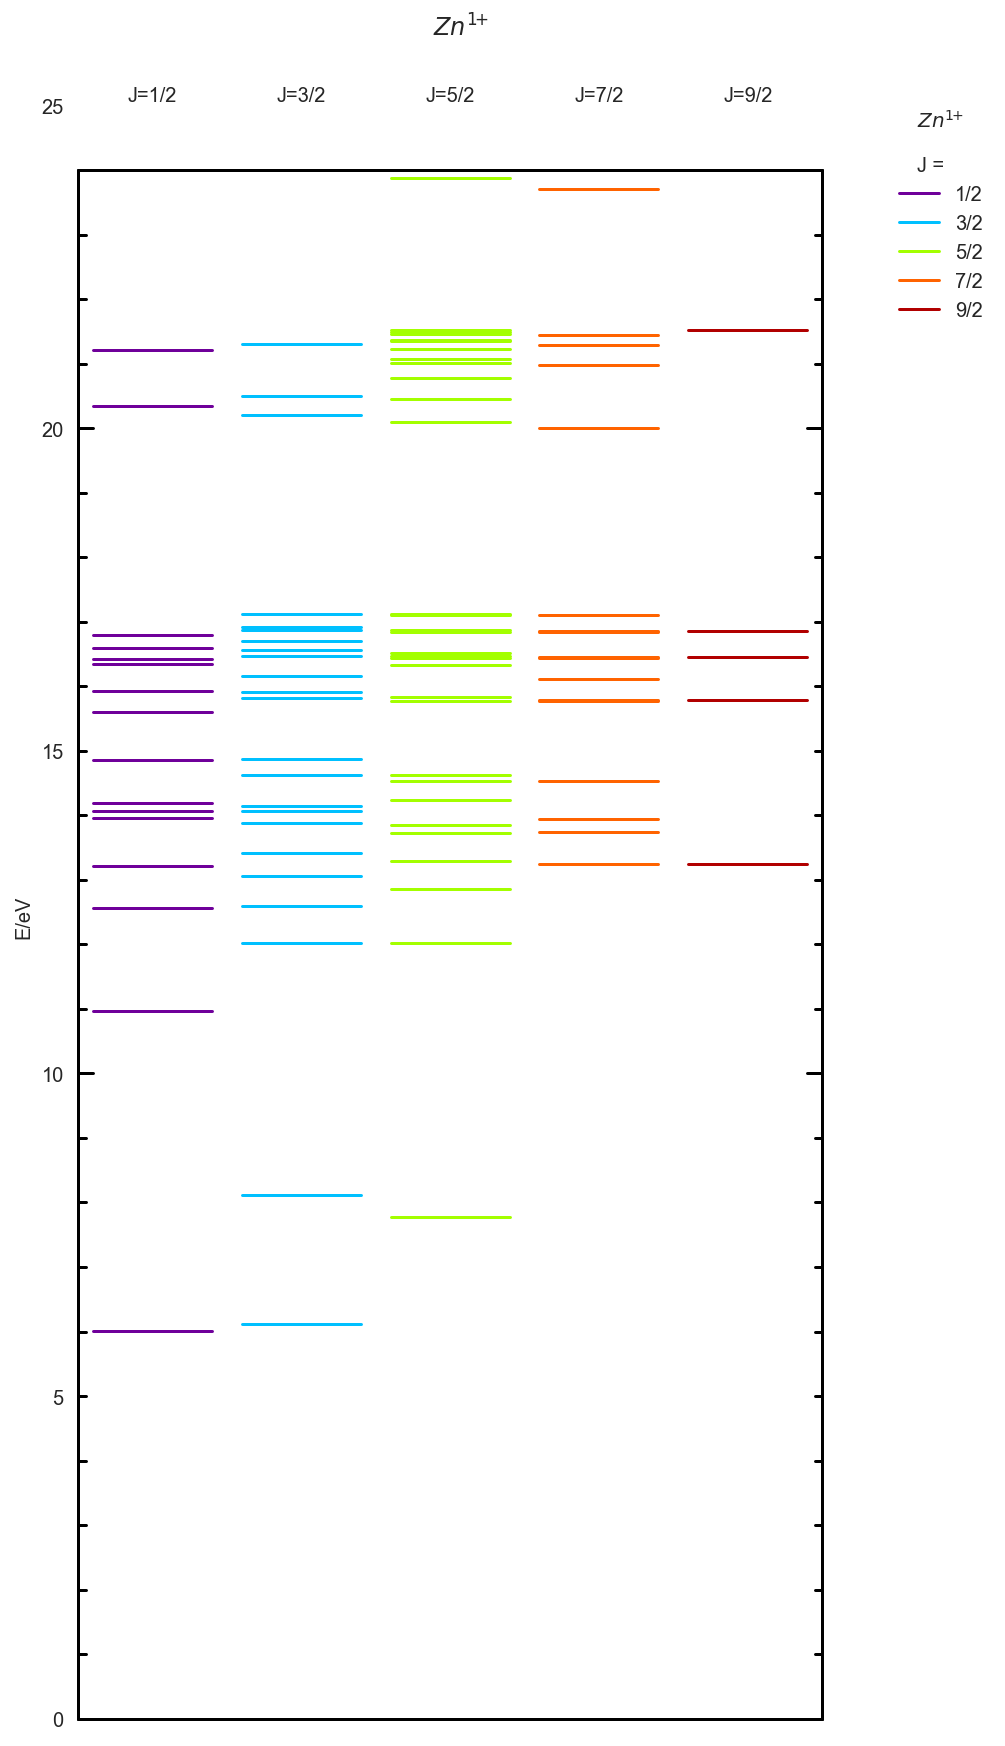

In [9]:
plt.style.use('seaborn-white')
element = 'Zn'
charge = 1
levels = atomic_levels[(atomic_levels['Element'] == element) & (atomic_levels['Charge'] == charge)]
Js = []
for l in levels['J']:
    Js.extend(l)
Js = np.array(list(set(Js)))
Js = Js[np.argsort(Js)]
offset = 0
valid_e_levels = levels[(levels['Level (eV)']>0 & (levels['Charge'] == charge))]['Level (eV)']
min_level = np.min(valid_e_levels)
max_level = np.max(valid_e_levels)
max_level = -np.inf
min_level = np.inf
plt.figure(figsize=(7,15))
colors = np.linspace(400,700,len(Js))
for J_index, J in enumerate(Js):
    good_levels = levels[levels['J'].map(lambda x: J in x)]['Level (eV)'] # convert to 1/cm
    if len(good_levels) == 0:
        continue
    for level_index, level in enumerate(good_levels):
        if level > max_level:
            max_level = level
        if level < min_level:
            min_level = level
        if level_index == 0:
            plt.plot([offset+0.1,offset+0.9],[level]*2,color=wavelength_to_rgb(colors[J_index]),label=J)
        else:
            plt.plot([offset+0.1,offset+0.9],[level]*2,color=wavelength_to_rgb(colors[J_index]))
    offset +=1
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,title='$%s^{%d\!\!+}$\n\nJ = ' % (element, charge))
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().set_frame_on(False)
plt.ylabel('E/eV')
for J_index, J in enumerate(Js):
    plt.text(J_index+0.5,max_level*1.05,'J='+str(J),ha='center')
if charge == 0:
    plt.title('$%s$\n' % (element))
else:
    plt.title('$%s^{%d\!\!+}$\n\n' % (element, charge))
plt.plot([0,0],[np.floor(min_level),np.ceil(max_level)],'k')
plt.plot([0,offset],[np.floor(min_level),np.floor(min_level)],'k')
plt.plot([0,offset],[np.ceil(max_level),np.ceil(max_level)],'k')
plt.plot([offset,offset],[np.floor(min_level),np.ceil(max_level)],'k')
for tick in np.linspace(np.ceil(min_level),
                        1+np.floor(max_level),
                       int(2+np.floor(max_level)-np.ceil(min_level))):
    dx = 0
    if tick % 10 == 0:
        dx = 0.05
    plt.plot([0,0.05+dx],[tick,tick],'k')
    plt.plot([offset,offset-0.05-dx],[tick,tick],'k')
plt.ylim(-0.2,max_level*1.05)
plt.xlim(-0.05,offset+0.2)
plt.show()

## Atomic Lines

In [10]:
atomic_lines = pd.read_pickle('./nist_atomic_spectra_database_lines.pkl')

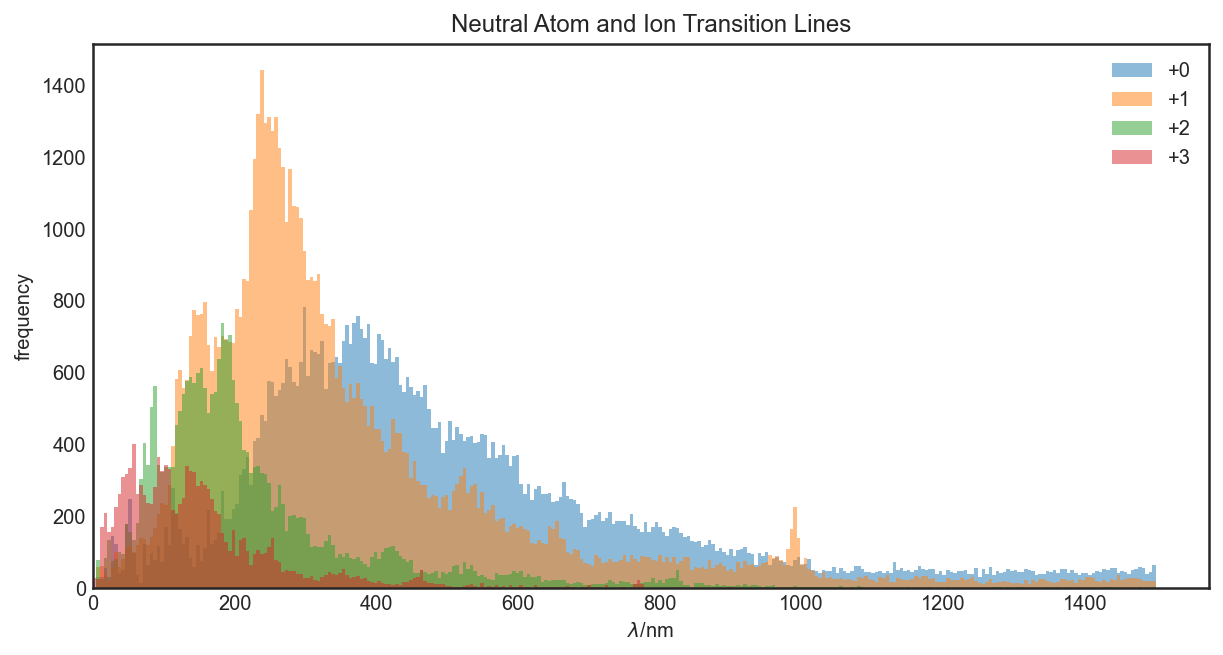

In [11]:
plt.figure(figsize=(10,5))
plt.style.use('seaborn-white')
for charge in [0,1,2,3]:
    plt.hist(atomic_lines[atomic_lines['charge'] == charge]['obs_wl_vac(nm)'],
             bins = np.linspace(0,1500,300), label="+"+str(charge),alpha=0.5)
plt.gca().set_xlim(left=0)
plt.legend()
plt.xlabel('$\lambda$/nm')
plt.ylabel('frequency')
plt.title('Neutral Atom and Ion Transition Lines')
plt.show()

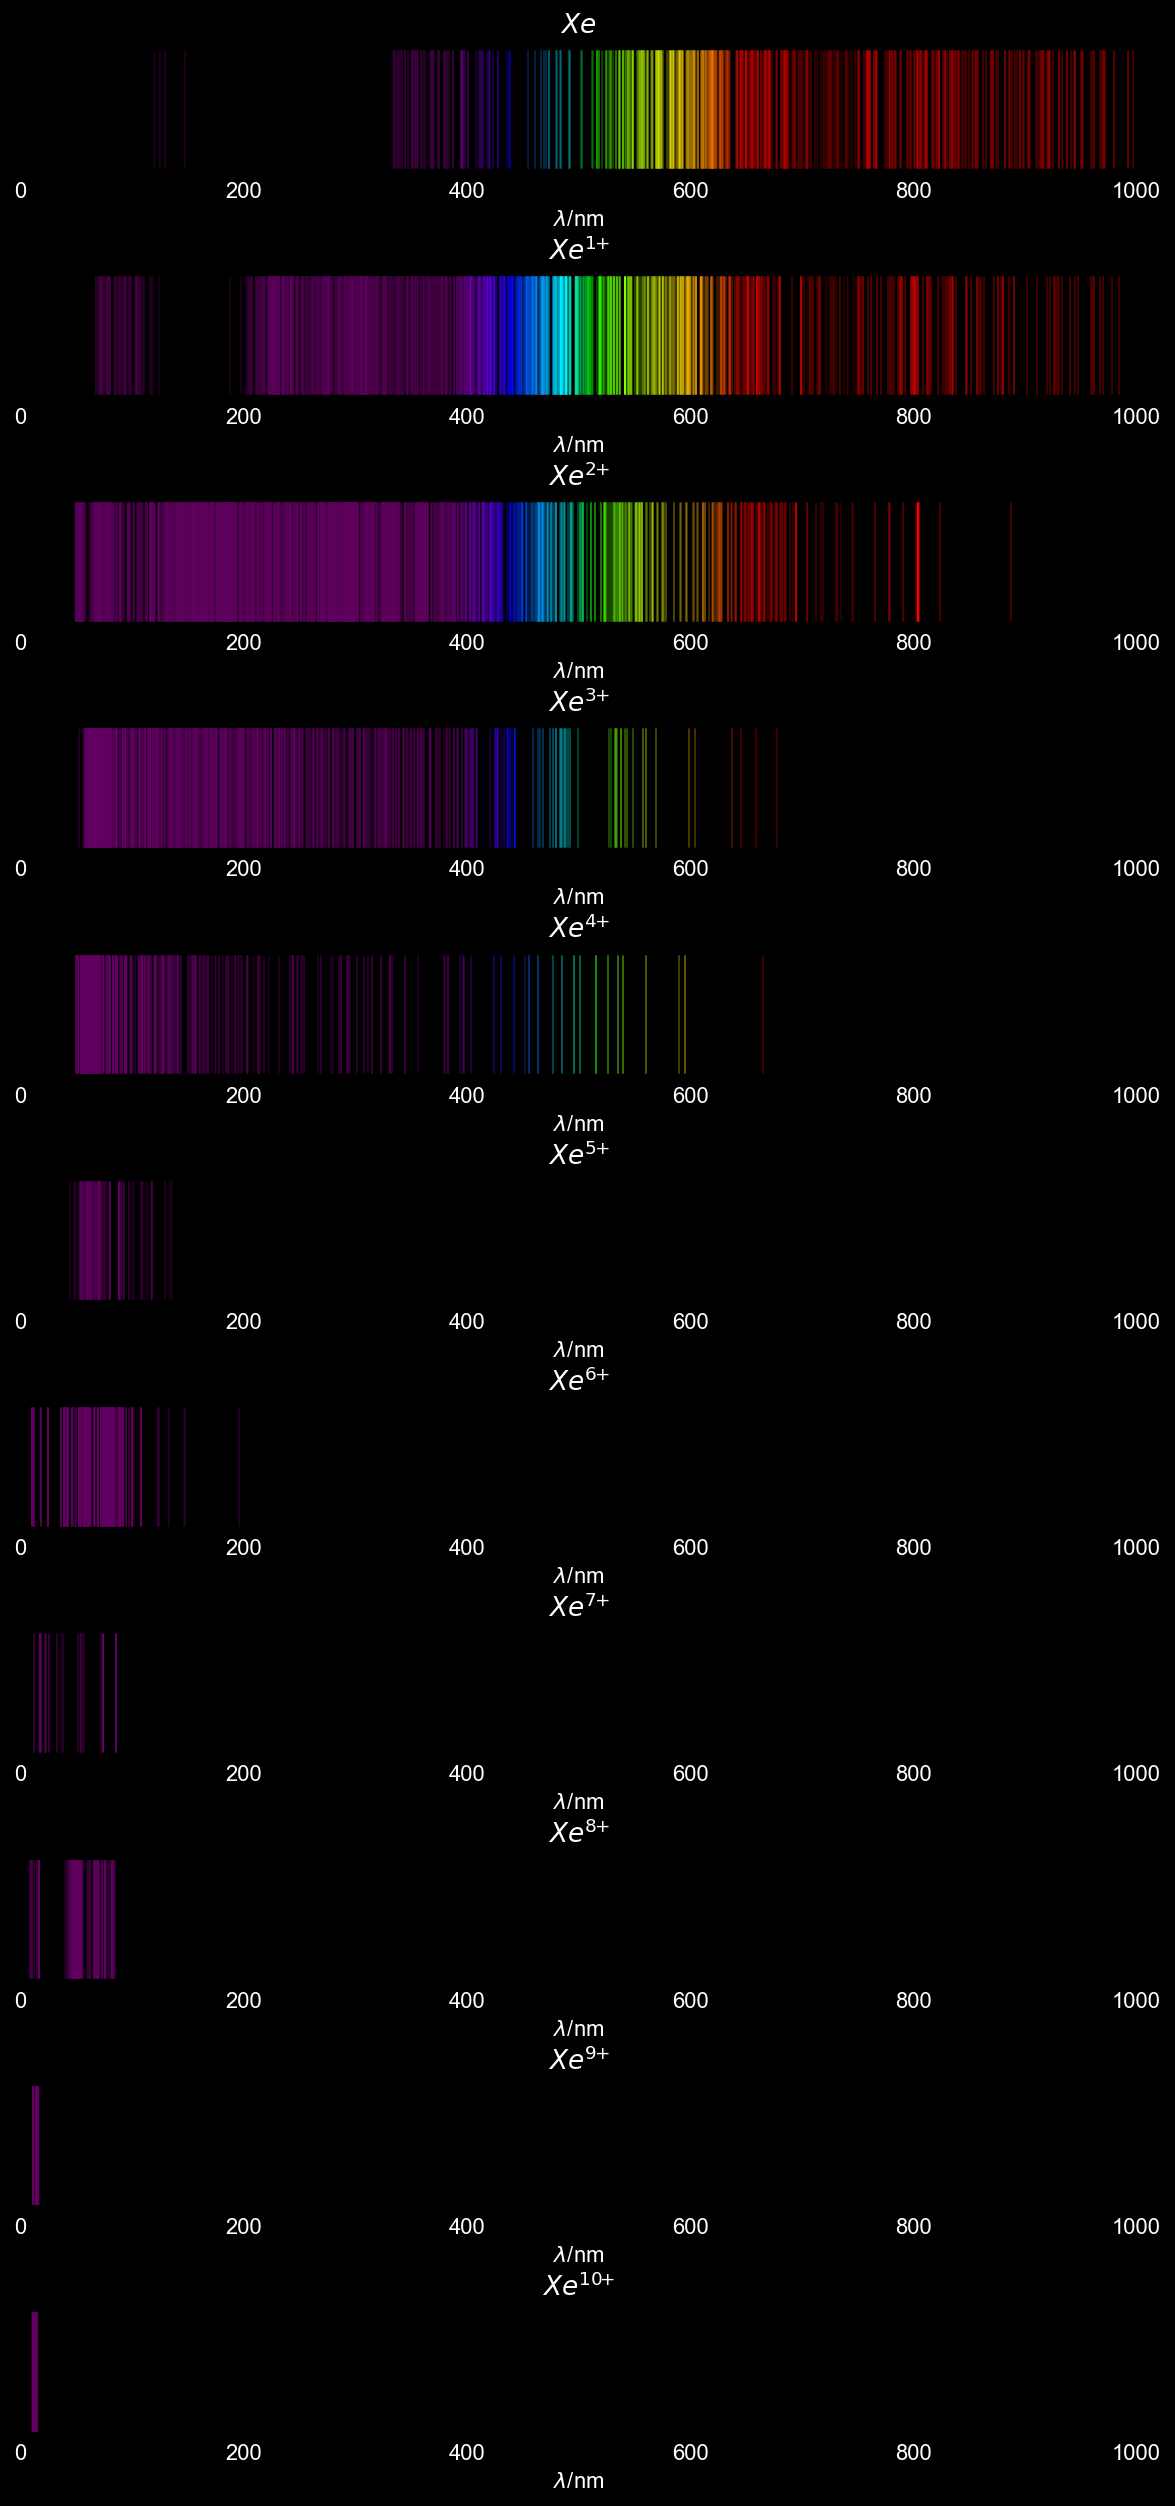

In [51]:
element = 'Xe' 
this_element = atomic_lines[(atomic_lines['element'] == element)]
charges = list(this_element['charge'].unique())
wave_type = 'obs_wl_vac(nm)'
fig,  axes = plt.subplots(nrows=len(charges),ncols=1, figsize=(10,2*len(charges)))
plt.style.use('dark_background')
plt.rcParams["font.size"] = "11"
for charge, axis in zip(charges, axes):
    intensities = this_element[(this_element['charge'] == charge)]['intens']
    good_intensities = ~np.isnan(intensities)
    lines = this_element[(this_element['charge'] == charge)][wave_type][good_intensities]
    intensities = intensities[good_intensities]
    intensities = (intensities / np.nanmax(intensities))
    if charge == 0:
        title = '$%s$' % (element)
    else:
        title='$%s^{%d\!\!+}$' % (element, charge)


    for l, op in zip(lines,intensities):
        axis.plot([l,l],[0,1],'k',alpha=min(1,0.25+op),color=wavelength_to_rgb(l),lw=1)
    axis.set_xlim(0,1000)
    axis.get_yaxis().set_visible(False)
    axis.set_frame_on(False)
    axis.set_xlabel('$\lambda$/nm')
    axis.set_title(title)
plt.subplots_adjust(hspace=0.75)
plt.show()